In [1]:
%matplotlib inline

from matplotlib_inline import backend_inline
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.nn.utils import weight_norm

from pytorch_tcn.tcn import TCN

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.metrics import r2_score

backend_inline.set_matplotlib_formats('svg')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
plt.rcParams['font.sans-serif'] = ['SimHei']

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps')
# device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')


## 加载数据

In [2]:
# convert str to datatime
# 将字符串转换为时间
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
# 加载.mat格式的数据
def loadMat(matfile):
    data_mat = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data_mat[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_mat = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data_mat.append(d1)

    return data_mat

# get capacity data
# 得到电池容量的数据
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = './datasets/NASA/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data_mat = loadMat(path)
    Battery[name] = getBatteryCapacity(data_mat)

Load Dataset B0005.mat ...


C:\Users\Coyle\AppData\Local\Temp\ipykernel_11964\3199085973.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


In [4]:
len(Battery['B0006'][0]), len(Battery['B0006'][1])

(168, 168)

## 画出数据

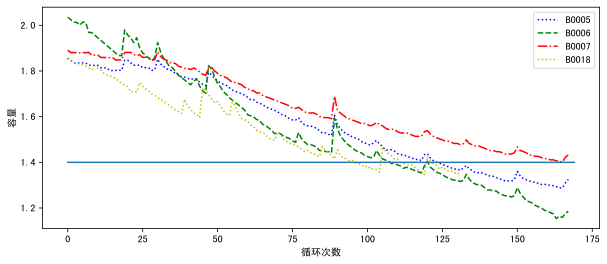

In [3]:
%matplotlib inline

def matplot_battery_list(battery_data_list):
    color_list = ['b:', 'g--', 'r-.', 'y:']
    # 1.创建画布
    plt.figure(figsize=(10, 4), dpi=80)
    plt.xlabel('循环次数')
    plt.ylabel('容量')

    # 2.绘制折线图
    for index, data in enumerate(battery_data_list):
        plt.plot([i for i in range(len(battery_data_list[index]))], battery_data_list[index], color_list[index])

    plt.plot([i for i in range(170)], [1.4] * 170)

    # 图例
    plt.legend([name for name in Battery_list])

Battery_data_list = [Battery['B0005'][1], Battery['B0006'][1], Battery['B0007'][1], Battery['B0018'][1]]
matplot_battery_list(Battery_data_list)

## 创建评估指标函数

In [4]:
threshold_xi = [0.7, 0.7, 0.75, 0.7]

# 平均绝对误差、均方根误差
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    r2 = r2_score(y_test, y_predict)
    return mae, rmse, r2

# 相对误差
# B0005 第125次循环后达到阈值1.4
# B0006 第109次循环后达到阈值1.4
# B0007 数据集中无任何值小于1.4，所以无法达到阈值1.4，所以设置为1.5，即第126次循环达到阈值1.5
# B0018 第97次循环后达到阈值1.4
def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), len(y_predict)
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i + 1]:
            true_re = i + 1
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold >= y_predict[i + 1]:
            pred_re = i + 1
            break
    return pred_re
    # return abs(true_re - pred_re) / true_re

# relative_error(Battery['B0007'][1], Battery['B0007'][1], 1.5)

## 构建训练序列数据

In [5]:
# 构建数据
# 采用 留一评估：一组数据为测试集，其他所有数据全部拿来训练
# train_x 的维度是 window_size ，总样本数为 421
# train_y 的维度是1，总样本数为421
# train_data 是模型预测时的真实数据，用来预测下一时刻的容量，长度为 window_size
# test_data 是 真实的容量数据，用来检验模型的各种参数

def build_seq(text, window_size):
    # text:list of capacity
    x, y = [], []
    for i in range(len(text) - window_size):
        sequence = text[i:i + window_size]
        target = text[i + 1:i + window_size + 1]
        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)

def get_train_test_data(data_list, battery_i, window_size=16):
    data_sequence = Battery[Battery_list[battery_i]][1]
    train_data, test_data = data_sequence[:window_size], data_sequence[window_size:]
    
    train_x, train_y = None, None
    for i, v in enumerate(data_list):
        if i != battery_i:
            data_x, data_y = build_seq(text=v, window_size=window_size)
            if train_x is None:
                train_x = data_x
                train_y = data_y
            else:
                train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)

def load_capacity_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

## 检验 train_iter 数据是否正确

In [6]:
train_x, train_y, train_data, test_data = get_train_test_data(Battery_data_list, 0, window_size=16)
train_x = torch.from_numpy(train_x.astype(np.float32))
train_y = torch.from_numpy(train_y.astype(np.float32))
train_iter = load_capacity_data((train_x, train_y), 2, is_train=False)

# 测试 train_iter 的数据是否正确
def validate_train_iter(train_iter):
    for x, y in train_iter:
        print(x.shape)
        print(y.shape)
        
        print(x)
        print(y)
        break



validate_train_iter(train_iter)

torch.Size([2, 16])
torch.Size([2, 16])
tensor([[2.0353, 2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682,
         1.9572, 1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892],
        [2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572,
         1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783]])
tensor([[2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572,
         1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783],
        [2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572, 1.9456,
         1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783, 1.8676]])


## 绘制 out 和  tgt_y的对比图

In [7]:
# 绘制 out  tgt_y的对比图
def matlab_make(out, tgt_y):
    color_list = ['b:', 'g:']
    # 1.创建画布
    fig = plt.figure(figsize=(7, 2), dpi=80)
    plt.xlabel('循环次数')
    plt.ylabel('容量')
    
    data_list = [
        {
            'name': 'out',
            'x': [i for i in range(len(out))],
            'y': out
        },
        {
            'name': 'tgt_y',
            'x': [i for i in range(len(tgt_y))],
            'y': tgt_y
        }
    ]

    # 2.绘制折线图
    for data,color in zip(data_list, color_list):
        plt.plot(data['x'], data['y'], color)


    # 图例
    plt.legend([data['name'] for data in data_list])
    
    display(fig)
    plt.close() 

# out_t = [1,2,3,4,5,6,7,8,9,10]
# tgt_y_t = [11,21,31,41,51,61,71,81,91,110]

# matlab_make(out_t, tgt_y_t)

## 随机种子

In [8]:
# 设置随机种子
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed)  # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

## 搭建模型 有词嵌入层 linear_embedding

In [9]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # 初始化Shape为(max_len, d_model)的PE (positional encoding)
        pe = torch.zeros(max_len, d_model)
        # 初始化一个tensor [[0, 1, 2, 3, ...]]
        position = torch.arange(0, max_len).unsqueeze(1)
        # 这里就是sin和cos括号中的内容，通过e和ln进行了变换
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        # 计算PE(pos, 2i)
        pe[:, 0::2] = torch.sin(position * div_term)
        # 计算PE(pos, 2i+1)
        pe[:, 1::2] = torch.cos(position * div_term)
        # 为了方便计算，在最外面在unsqueeze出一个batch
        pe = pe.unsqueeze(0)
        # 如果一个参数不参与梯度下降，但又希望保存model的时候将其保存下来
        # 这个时候就可以用register_buffer
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x 为embedding后的inputs，例如(1,7, 128)，batch size为1,7个单词，单词维度为128
        """
        # 将x和positional encoding相加。
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)


class Net(nn.Module):

    def __init__(self, d_model=128, nhead=16, num_encoder_layers=2, dim_feedforward=512, dropout=0.1,
                num_channels=[64], kernel_size=7, tcn_dropout=0.1):
        super(Net, self).__init__()

        # 定义TransformerEncoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=dim_feedforward, 
                                                    dropout=dropout, 
                                                    batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        self.linear_embedding = nn.Linear(1, d_model)

        # 定义位置编码器
        self.positional_encoding = PositionalEncoding(d_model, dropout=0)
        
        # tcn
        # self.tcn = TemporalConvNet(d_model, num_channels, kernel_size=kernel_size, dropout=tcn_dropout)
        self.tcn = TCN(d_model, num_channels, kernel_size=kernel_size, dropout=dropout)

        # 定义最后的线性层，这里并没有用Softmax，因为没必要。
        # 因为后面的CrossEntropyLoss中自带了
        self.predictor = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        
        # 对 x 进行编码
        x = x.reshape(x.shape[0], x.shape[1], 1)
        
        x = self.linear_embedding(x)
        # print(x.shape)
        # 给x的token增加位置信息
        x = self.positional_encoding(x)
        # print(x.shape)
        
        out = self.transformerEncoder(x)
        # print(out.shape)
        
        # tcn
        out = out.permute(0, 2, 1)
        # print(out.shape)
        
        out = self.tcn(out)
        # print(out.shape)
        
        out = out.permute(0, 2, 1) # 输出 out shape: (batch_size, seq_len, d_model * 2)
        # print(out.shape)
        
        out = self.predictor(out)
    
        return out

## 搭建模型 没有词嵌入层 linear_embedding

In [42]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # 初始化Shape为(max_len, d_model)的PE (positional encoding)
        pe = torch.zeros(max_len, d_model)
        # 初始化一个tensor [[0, 1, 2, 3, ...]]
        position = torch.arange(0, max_len).unsqueeze(1)
        # 这里就是sin和cos括号中的内容，通过e和ln进行了变换
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        # 计算PE(pos, 2i)
        pe[:, 0::2] = torch.sin(position * div_term)
        # 计算PE(pos, 2i+1)
        pe[:, 1::2] = torch.cos(position * div_term)
        # 为了方便计算，在最外面在unsqueeze出一个batch
        pe = pe.unsqueeze(0)
        # 如果一个参数不参与梯度下降，但又希望保存model的时候将其保存下来
        # 这个时候就可以用register_buffer
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x 为embedding后的inputs，例如(1,7, 128)，batch size为1,7个单词，单词维度为128
        """
        # 将x和positional encoding相加。
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)


class Net(nn.Module):

    def __init__(self, d_model=16, nhead=16, num_encoder_layers=2, dim_feedforward=64, dropout=0.1,
                num_channels=[16], kernel_size=3, tcn_dropout=0.1):
        super(Net, self).__init__()

        # 定义TransformerEncoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=dim_feedforward, 
                                                    dropout=dropout, 
                                                    batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        # self.linear_embedding = nn.Linear(1, d_model)

        # 定义位置编码器
        self.positional_encoding = PositionalEncoding(d_model, dropout=0)
        
        # tcn
        # self.tcn = TemporalConvNet(d_model, num_channels, kernel_size=kernel_size, dropout=tcn_dropout)
        self.tcn = TCN(d_model, num_channels, kernel_size=kernel_size, dropout=dropout)

        # 定义最后的线性层，这里并没有用Softmax，因为没必要。
        # 因为后面的CrossEntropyLoss中自带了
        self.predictor = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        
        # 对 x 进行编码
        # x = x.reshape(x.shape[0], x.shape[1], 1)
        x = x.reshape(x.shape[0], 1, x.shape[1])
        
        # x = self.linear_embedding(x)
        # print(x.shape)
        # 给x的token增加位置信息
        x = self.positional_encoding(x)
        # print(x.shape)
        
        out = self.transformerEncoder(x)
        # print(out.shape)
        
        # tcn
        out = out.permute(0, 2, 1)
        # print(out.shape)
        
        out = self.tcn(out)
        # print(out.shape)
        
        out = out.permute(0, 2, 1) # 输出 out shape: (batch_size, seq_len, d_model * 2)
        # print(out.shape)
        
        out = self.predictor(out)
    
        return out

## 测试模型的输出形状

In [35]:
# 测试模型的输出形状
net = Net(d_model=16, num_channels=[16] * 2).to(device)

# src = torch.LongTensor([[0, 3, 4, 5, 6, 1, 2, 2]])
x = torch.ones((30, 16), dtype=torch.float32).to(device)

out = net(x)
print(out.size())

torch.Size([30, 1, 16])
torch.Size([30, 1, 1])


## 一个批次的训练函数

In [44]:
def train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity): 
    # 将模型设置为训练模式
    net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    for x, y in train_iter:
        # 计算梯度并更新参数
        x = torch.reshape(x / Rated_Capacity, (-1, x.shape[-1])).type(torch.float32)
        
        y = torch.reshape(y[:, -1] / Rated_Capacity, (-1, 1)).type(torch.float32)
        
        x, y = x.to(device), y.to(device)
        # print('y.shape', y.shape)
        out = net(x)
    
        
        l = loss(out.reshape(-1), y.reshape(-1))
        
        updater.zero_grad()
        l.backward()
        updater.step()
    
    return l

## 总的训练函数

In [27]:
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, r2_epoch_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        print(pre_list[-1])
        if np.isnan(pre_list[-1]):
            print('碰到nan')
            break
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        re = relative_error(test_y, pre_list, threshold=Rated_Capacity * 0.7)

        if (len(re_epoch_list) == 0 or (r2_epoch_list[-1] < r2)):
            print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f} , R2:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, r2))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], r2_epoch_list[-1]

## 预测函数

In [28]:
def predict(net, train_data, test_data, Rated_Capacity):
    net = net.eval()
    
    x = train_data.copy()
    x = np.array(x)
    x = torch.from_numpy(x).type(torch.float32).to(device)
    x = torch.reshape(x / Rated_Capacity, (1, -1)) # shape: (batch_size, input_size)
    
    pre_list = []
    while len(pre_list) < len(test_data):
        
        
        out = net(x)
        x = torch.cat([x[:, 1:], out[:, -1]], dim=1)
        
        pred = out.reshape(-1)
        
        pred_next_point = pred.cpu().data.numpy()[-1] * Rated_Capacity
        
        pre_list.append(pred_next_point)
        
    return pre_list
        
    
# x = train_data.copy()
# pred_list = predict(net, train_data, test_data, 2)
# print((pred_list))
# print((test_data))

# print(len(pred_list))
# print(len(test_data))
# matlab_make(pred_list, test_data)

## 以4个评价指标的和为判断函数 开始训练

In [38]:
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, r2_epoch_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        # print(pre_list[-1])
        if np.isnan(pre_list[-1]):
            print('--------------------------------------------碰到nan')
            break
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        re = relative_error(test_y, pre_list, threshold=Rated_Capacity * 0.7)
        currentSum = 0
        lastSum = 0
        
        if (len(re_epoch_list) > 0):
            currentSum = re + mae + rmse - r2
            lastSum = re_epoch_list[-1] + mae_epoch_list[-1] + rmse_epoch_list[-1] - r2_epoch_list[-1]

        if (len(re_epoch_list) == 0 or (currentSum < lastSum)):
            print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f} , R2:{:<6.4f} , currentSum:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, r2, currentSum))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], r2_epoch_list[-1]


# 电池额定容量
Rated_Capacity = 2.0

# 超参数
d_model = 16
nhead = 4
num_encoder_layers = 2
dim_feedforward = 32
num_channels = [16] * 2
kernel_size = 3

batch_size = 30
lr = 0.0001
weight_decay = 0.0005
num_epochs = 500
window_size = 16

# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], []
for seed in range(0, 10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
    # for i in range(1):
        train_x, train_y, train_data, test_data = get_train_test_data(Battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(d_model=d_model, nhead=nhead,
                  num_encoder_layers=num_encoder_layers, 
                  dim_feedforward=dim_feedforward,
                  num_channels=num_channels,
                  kernel_size=kernel_size)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print(f'r2 mean: {np.array(r2_s).mean()}')
    print('---------------------------------')
    
    re_seed_all.append(np.array(re_s).mean())
    mae_seed_all.append(np.array(mae_s).mean())
    rmse_seed_all.append(np.array(rmse_s).mean())
    r2_seed_all.append(np.array(r2_s).mean())

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   平均值   ---------------------')
print(f're mean: {np.array(re_seed_all).mean()}')
print(f'mae mean: {np.array(mae_seed_all).mean()}')
print(f'rmse mean: {np.array(rmse_seed_all).mean()}')
print(f'r2 mean: {np.array(r2_seed_all).mean()}')
print('---------------------------------------------')

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 max: {np.array(r2_seed_all).max()}')
print('---------------------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 B0005 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0005, epoch:1    , loss:0.0313566588 , MAE:0.6489 , RMSE:0.6701 , RE:0.9908 , R2:-12.8998 , currentSum:0.0000
seed: 0, 测试集: B0005, epoch:2    , loss:0.0218166914 , MAE:0.3696 , RMSE:0.4067 , RE:0.9908 , R2:-4.1201 , currentSum:5.8872
seed: 0, 测试集: B0005, epoch:3    , loss:0.0150953867 , MAE:0.2798 , RMSE:0.3279 , RE:0.9817 , R2:-2.3286 , currentSum:3.9180
seed: 0, 测试集: B0005, epoch:4    , loss:0.0143136298 , MAE:0.2771 , RMSE:0.3257 , RE:0.9817 , R2:-2.2832 , currentSum:3.8676
seed: 0, 测试集: B0005, epoch:5    , loss:0.0120290127 , MAE:0.2670 , RMSE:0.3171 , RE:0.9817 , R2:-2.1131 , currentSum:3.6789
seed: 0, 测试集: B0005, epoch:6    , loss:0.0111765265 , MAE:0.2434 , RMSE:0.2973 , RE:0.9817 , R2:-1.7366 , currentSum:3.2590
seed: 0, 测试集: B0005, epoch:7    , loss:0.0130987335 , MAE:0.2185 , RMSE:0.2751 , RE:0.9817 , R2:-1.3

seed: 0, 测试集: B0007, epoch:5    , loss:0.2843554616 , MAE:0.6696 , RMSE:0.6852 , RE:0.9934 , R2:-19.9642 , currentSum:22.3125
seed: 0, 测试集: B0007, epoch:6    , loss:0.2168196738 , MAE:0.3962 , RMSE:0.4224 , RE:0.9934 , R2:-6.9665 , currentSum:8.7786
seed: 0, 测试集: B0007, epoch:7    , loss:0.1562100649 , MAE:0.1713 , RMSE:0.2194 , RE:0.0000 , R2:-1.1485 , currentSum:1.5392
seed: 0, 测试集: B0007, epoch:8    , loss:0.1147616953 , MAE:0.1281 , RMSE:0.1484 , RE:0.0000 , R2:0.0168 , currentSum:0.2597
seed: 0, 测试集: B0007, epoch:108  , loss:0.0070218579 , MAE:0.1208 , RMSE:0.1453 , RE:0.0000 , R2:0.0569 , currentSum:0.2092
seed: 0, 测试集: B0007, epoch:110  , loss:0.0058954717 , MAE:0.1198 , RMSE:0.1439 , RE:0.0000 , R2:0.0753 , currentSum:0.1883
seed: 0, 测试集: B0007, epoch:114  , loss:0.0062284223 , MAE:0.1165 , RMSE:0.1386 , RE:0.0000 , R2:0.1426 , currentSum:0.1125
seed: 0, 测试集: B0007, epoch:119  , loss:0.0068131918 , MAE:0.1145 , RMSE:0.1369 , RE:0.0000 , R2:0.1627 , currentSum:0.0887
seed: 0, 测试

seed: 1, 测试集: B0005, epoch:66   , loss:0.0083391508 , MAE:0.1505 , RMSE:0.1710 , RE:0.3945 , R2:0.0948 , currentSum:0.6212
seed: 1, 测试集: B0005, epoch:67   , loss:0.0080377739 , MAE:0.1504 , RMSE:0.1702 , RE:0.3945 , R2:0.1035 , currentSum:0.6116
seed: 1, 测试集: B0005, epoch:70   , loss:0.0089665046 , MAE:0.1494 , RMSE:0.1696 , RE:0.3945 , R2:0.1099 , currentSum:0.6036
seed: 1, 测试集: B0005, epoch:73   , loss:0.0085498691 , MAE:0.1484 , RMSE:0.1688 , RE:0.3945 , R2:0.1182 , currentSum:0.5935
seed: 1, 测试集: B0005, epoch:74   , loss:0.0086553590 , MAE:0.1489 , RMSE:0.1676 , RE:0.3945 , R2:0.1309 , currentSum:0.5800
seed: 1, 测试集: B0005, epoch:75   , loss:0.0076675904 , MAE:0.1477 , RMSE:0.1673 , RE:0.3945 , R2:0.1339 , currentSum:0.5756
seed: 1, 测试集: B0005, epoch:78   , loss:0.0069253268 , MAE:0.1465 , RMSE:0.1666 , RE:0.3945 , R2:0.1407 , currentSum:0.5669
seed: 1, 测试集: B0005, epoch:79   , loss:0.0070111323 , MAE:0.1460 , RMSE:0.1646 , RE:0.3945 , R2:0.1609 , currentSum:0.5443
seed: 1, 测试集: B0

seed: 1, 测试集: B0018, epoch:19   , loss:0.0220560841 , MAE:0.1230 , RMSE:0.1356 , RE:0.4321 , R2:-0.1057 , currentSum:0.7964
seed: 1, 测试集: B0018, epoch:20   , loss:0.0244168788 , MAE:0.1210 , RMSE:0.1328 , RE:0.4321 , R2:-0.0594 , currentSum:0.7453
seed: 1, 测试集: B0018, epoch:21   , loss:0.0195794925 , MAE:0.1208 , RMSE:0.1324 , RE:0.4321 , R2:-0.0537 , currentSum:0.7390
seed: 1, 测试集: B0018, epoch:22   , loss:0.0176788643 , MAE:0.1184 , RMSE:0.1292 , RE:0.4321 , R2:-0.0038 , currentSum:0.6835
seed: 1, 测试集: B0018, epoch:23   , loss:0.0155930873 , MAE:0.1154 , RMSE:0.1262 , RE:0.4321 , R2:0.0422 , currentSum:0.6315
seed: 1, 测试集: B0018, epoch:24   , loss:0.0147409691 , MAE:0.1143 , RMSE:0.1255 , RE:0.4321 , R2:0.0543 , currentSum:0.6176
seed: 1, 测试集: B0018, epoch:26   , loss:0.0125550497 , MAE:0.1131 , RMSE:0.1252 , RE:0.4321 , R2:0.0574 , currentSum:0.6130
seed: 1, 测试集: B0018, epoch:31   , loss:0.0117879016 , MAE:0.1121 , RMSE:0.1253 , RE:0.4321 , R2:0.0570 , currentSum:0.6124
seed: 1, 测试集

seed: 2, 测试集: B0007, epoch:46   , loss:0.0026360154 , MAE:0.0638 , RMSE:0.0718 , RE:0.2434 , R2:0.7699 , currentSum:-0.3909
seed: 2, 测试集: B0007, epoch:49   , loss:0.0024401944 , MAE:0.0365 , RMSE:0.0428 , RE:0.1184 , R2:0.9182 , currentSum:-0.7205
seed: 2, 测试集: B0007, epoch:67   , loss:0.0014781704 , MAE:0.0479 , RMSE:0.0551 , RE:0.0329 , R2:0.8642 , currentSum:-0.7283
seed: 2, 测试集: B0007, epoch:80   , loss:0.0014077744 , MAE:0.0383 , RMSE:0.0438 , RE:0.0987 , R2:0.9144 , currentSum:-0.7336
seed: 2, 测试集: B0007, epoch:87   , loss:0.0013110781 , MAE:0.0397 , RMSE:0.0442 , RE:0.0526 , R2:0.9126 , currentSum:-0.7761
seed: 2, 测试集: B0007, epoch:94   , loss:0.0010307089 , MAE:0.0450 , RMSE:0.0493 , RE:0.0000 , R2:0.8916 , currentSum:-0.7973
seed: 2, 测试集: B0007, epoch:112  , loss:0.0008688895 , MAE:0.0328 , RMSE:0.0389 , RE:0.0066 , R2:0.9325 , currentSum:-0.8542
--------------------------------------------碰到nan
以电池 B0018 为测试数据的 数据集 开始训练
seed: 2, 测试集: B0018, epoch:1    , loss:0.5709544420 , MA

seed: 3, 测试集: B0005, epoch:16   , loss:0.0176091399 , MAE:0.1592 , RMSE:0.1814 , RE:0.3945 , R2:-0.0189 , currentSum:0.7541
seed: 3, 测试集: B0005, epoch:17   , loss:0.0159859005 , MAE:0.1590 , RMSE:0.1814 , RE:0.3945 , R2:-0.0183 , currentSum:0.7532
seed: 3, 测试集: B0005, epoch:18   , loss:0.0172402635 , MAE:0.1592 , RMSE:0.1811 , RE:0.3945 , R2:-0.0153 , currentSum:0.7501
seed: 3, 测试集: B0005, epoch:24   , loss:0.0146419303 , MAE:0.1605 , RMSE:0.1808 , RE:0.3945 , R2:-0.0118 , currentSum:0.7476
seed: 3, 测试集: B0005, epoch:26   , loss:0.0137650212 , MAE:0.1598 , RMSE:0.1800 , RE:0.3945 , R2:-0.0033 , currentSum:0.7376
seed: 3, 测试集: B0005, epoch:28   , loss:0.0097903535 , MAE:0.1595 , RMSE:0.1795 , RE:0.3945 , R2:0.0023 , currentSum:0.7313
seed: 3, 测试集: B0005, epoch:30   , loss:0.0126089696 , MAE:0.1595 , RMSE:0.1793 , RE:0.3945 , R2:0.0049 , currentSum:0.7284
seed: 3, 测试集: B0005, epoch:64   , loss:0.0056917253 , MAE:0.1526 , RMSE:0.1773 , RE:0.3945 , R2:0.0274 , currentSum:0.6970
seed: 3, 测试

seed: 3, 测试集: B0007, epoch:16   , loss:0.0196276251 , MAE:0.1838 , RMSE:0.2351 , RE:0.0000 , R2:-1.4673 , currentSum:1.8862
seed: 3, 测试集: B0007, epoch:17   , loss:0.0153290220 , MAE:0.1684 , RMSE:0.2180 , RE:0.0000 , R2:-1.1210 , currentSum:1.5074
seed: 3, 测试集: B0007, epoch:18   , loss:0.0136821233 , MAE:0.1615 , RMSE:0.2094 , RE:0.0000 , R2:-0.9585 , currentSum:1.3294
seed: 3, 测试集: B0007, epoch:19   , loss:0.0182184707 , MAE:0.1541 , RMSE:0.1996 , RE:0.0000 , R2:-0.7788 , currentSum:1.1325
seed: 3, 测试集: B0007, epoch:20   , loss:0.0140998345 , MAE:0.1497 , RMSE:0.1933 , RE:0.0000 , R2:-0.6680 , currentSum:1.0110
seed: 3, 测试集: B0007, epoch:21   , loss:0.0107932789 , MAE:0.1468 , RMSE:0.1890 , RE:0.0000 , R2:-0.5943 , currentSum:0.9300
seed: 3, 测试集: B0007, epoch:22   , loss:0.0132613368 , MAE:0.1428 , RMSE:0.1831 , RE:0.0000 , R2:-0.4974 , currentSum:0.8233
seed: 3, 测试集: B0007, epoch:23   , loss:0.0145767769 , MAE:0.1380 , RMSE:0.1754 , RE:0.0000 , R2:-0.3731 , currentSum:0.6865
seed: 3,

seed: 3, 测试集: B0018, epoch:12   , loss:0.0071704127 , MAE:0.1113 , RMSE:0.1212 , RE:0.4321 , R2:0.1169 , currentSum:0.5477
seed: 3, 测试集: B0018, epoch:14   , loss:0.0057203760 , MAE:0.1035 , RMSE:0.1149 , RE:0.4321 , R2:0.2072 , currentSum:0.4433
seed: 3, 测试集: B0018, epoch:16   , loss:0.0076498701 , MAE:0.1029 , RMSE:0.1133 , RE:0.4321 , R2:0.2282 , currentSum:0.4201
seed: 3, 测试集: B0018, epoch:17   , loss:0.0058528613 , MAE:0.1005 , RMSE:0.1108 , RE:0.4321 , R2:0.2625 , currentSum:0.3808
seed: 3, 测试集: B0018, epoch:20   , loss:0.0043433728 , MAE:0.0857 , RMSE:0.0958 , RE:0.4321 , R2:0.4490 , currentSum:0.1645
seed: 3, 测试集: B0018, epoch:22   , loss:0.0034094730 , MAE:0.0833 , RMSE:0.0932 , RE:0.4321 , R2:0.4777 , currentSum:0.1309
seed: 3, 测试集: B0018, epoch:23   , loss:0.0050157774 , MAE:0.0769 , RMSE:0.0882 , RE:0.4321 , R2:0.5325 , currentSum:0.0648
seed: 3, 测试集: B0018, epoch:25   , loss:0.0031318315 , MAE:0.0725 , RMSE:0.0876 , RE:0.4321 , R2:0.5391 , currentSum:0.0531
seed: 3, 测试集: B0

seed: 4, 测试集: B0005, epoch:43   , loss:0.0219876561 , MAE:0.1655 , RMSE:0.2040 , RE:0.3945 , R2:-0.2886 , currentSum:1.0526
seed: 4, 测试集: B0005, epoch:44   , loss:0.0184751134 , MAE:0.1645 , RMSE:0.2023 , RE:0.3945 , R2:-0.2667 , currentSum:1.0280
seed: 4, 测试集: B0005, epoch:45   , loss:0.0183324683 , MAE:0.1616 , RMSE:0.1969 , RE:0.3945 , R2:-0.2002 , currentSum:0.9533
seed: 4, 测试集: B0005, epoch:46   , loss:0.0205018688 , MAE:0.1602 , RMSE:0.1939 , RE:0.3945 , R2:-0.1634 , currentSum:0.9119
seed: 4, 测试集: B0005, epoch:47   , loss:0.0228952337 , MAE:0.1570 , RMSE:0.1869 , RE:0.3945 , R2:-0.0818 , currentSum:0.8203
seed: 4, 测试集: B0005, epoch:48   , loss:0.0164745413 , MAE:0.1561 , RMSE:0.1848 , RE:0.3945 , R2:-0.0573 , currentSum:0.7927
seed: 4, 测试集: B0005, epoch:50   , loss:0.0162633490 , MAE:0.1537 , RMSE:0.1795 , RE:0.3945 , R2:0.0029 , currentSum:0.7248
seed: 4, 测试集: B0005, epoch:51   , loss:0.0158758238 , MAE:0.1534 , RMSE:0.1789 , RE:0.3945 , R2:0.0096 , currentSum:0.7172
seed: 4, 测

seed: 4, 测试集: B0007, epoch:233  , loss:0.0025289571 , MAE:0.0618 , RMSE:0.0723 , RE:0.0000 , R2:0.7669 , currentSum:-0.6329
seed: 4, 测试集: B0007, epoch:240  , loss:0.0028067401 , MAE:0.0555 , RMSE:0.0657 , RE:0.0000 , R2:0.8071 , currentSum:-0.6858
seed: 4, 测试集: B0007, epoch:268  , loss:0.0020680190 , MAE:0.0544 , RMSE:0.0650 , RE:0.0000 , R2:0.8116 , currentSum:-0.6922
seed: 4, 测试集: B0007, epoch:269  , loss:0.0020541262 , MAE:0.0539 , RMSE:0.0645 , RE:0.0000 , R2:0.8140 , currentSum:-0.6956
seed: 4, 测试集: B0007, epoch:280  , loss:0.0021499689 , MAE:0.0535 , RMSE:0.0634 , RE:0.0000 , R2:0.8205 , currentSum:-0.7036
seed: 4, 测试集: B0007, epoch:306  , loss:0.0017000283 , MAE:0.0502 , RMSE:0.0629 , RE:0.0000 , R2:0.8236 , currentSum:-0.7105
seed: 4, 测试集: B0007, epoch:312  , loss:0.0016973845 , MAE:0.0502 , RMSE:0.0610 , RE:0.0000 , R2:0.8337 , currentSum:-0.7225
seed: 4, 测试集: B0007, epoch:342  , loss:0.0015186472 , MAE:0.0452 , RMSE:0.0581 , RE:0.0000 , R2:0.8494 , currentSum:-0.7461
seed: 4,

seed: 5, 测试集: B0005, epoch:263  , loss:0.0013557116 , MAE:0.0884 , RMSE:0.1003 , RE:0.3945 , R2:0.6887 , currentSum:-0.1055
seed: 5, 测试集: B0005, epoch:300  , loss:0.0014282085 , MAE:0.0633 , RMSE:0.0700 , RE:0.3945 , R2:0.8484 , currentSum:-0.3206
--------------------------------------------碰到nan
以电池 B0006 为测试数据的 数据集 开始训练
seed: 5, 测试集: B0006, epoch:1    , loss:0.7207314968 , MAE:1.7376 , RMSE:1.7495 , RE:0.9892 , R2:-61.7678 , currentSum:0.0000
seed: 5, 测试集: B0006, epoch:2    , loss:0.5157756805 , MAE:1.3900 , RMSE:1.4055 , RE:0.9892 , R2:-39.5072 , currentSum:43.2919
seed: 5, 测试集: B0006, epoch:3    , loss:0.3908434212 , MAE:1.0502 , RMSE:1.0726 , RE:0.9892 , R2:-22.5928 , currentSum:25.7048
seed: 5, 测试集: B0006, epoch:4    , loss:0.2931513488 , MAE:0.7543 , RMSE:0.7878 , RE:0.9892 , R2:-11.7282 , currentSum:14.2597
seed: 5, 测试集: B0006, epoch:5    , loss:0.1807274520 , MAE:0.5069 , RMSE:0.5564 , RE:0.9892 , R2:-5.3493 , currentSum:7.4019
seed: 5, 测试集: B0006, epoch:6    , loss:0.13395059

seed: 6, 测试集: B0005, epoch:6    , loss:0.2143284976 , MAE:0.8551 , RMSE:0.8687 , RE:0.9908 , R2:-22.3628 , currentSum:25.0775
seed: 6, 测试集: B0005, epoch:7    , loss:0.1442528516 , MAE:0.4801 , RMSE:0.5078 , RE:0.9908 , R2:-6.9812 , currentSum:8.9599
seed: 6, 测试集: B0005, epoch:8    , loss:0.1254050285 , MAE:0.2190 , RMSE:0.2752 , RE:0.9725 , R2:-1.3452 , currentSum:2.8119
seed: 6, 测试集: B0005, epoch:9    , loss:0.0885572284 , MAE:0.1550 , RMSE:0.1787 , RE:0.3945 , R2:0.0115 , currentSum:0.7167
seed: 6, 测试集: B0005, epoch:36   , loss:0.0211784579 , MAE:0.1578 , RMSE:0.1777 , RE:0.3945 , R2:0.0226 , currentSum:0.7074
seed: 6, 测试集: B0005, epoch:40   , loss:0.0157982409 , MAE:0.1572 , RMSE:0.1774 , RE:0.3945 , R2:0.0258 , currentSum:0.7032
seed: 6, 测试集: B0005, epoch:44   , loss:0.0155772930 , MAE:0.1573 , RMSE:0.1773 , RE:0.3945 , R2:0.0266 , currentSum:0.7025
seed: 6, 测试集: B0005, epoch:46   , loss:0.0150256762 , MAE:0.1568 , RMSE:0.1771 , RE:0.3945 , R2:0.0286 , currentSum:0.6999
seed: 6, 测试

seed: 6, 测试集: B0007, epoch:3    , loss:0.0716381148 , MAE:0.8256 , RMSE:0.8393 , RE:0.9934 , R2:-30.4506 , currentSum:33.1089
seed: 6, 测试集: B0007, epoch:4    , loss:0.0530321710 , MAE:0.5547 , RMSE:0.5746 , RE:0.9934 , R2:-13.7409 , currentSum:15.8636
seed: 6, 测试集: B0007, epoch:5    , loss:0.0408129320 , MAE:0.3804 , RMSE:0.4086 , RE:0.9934 , R2:-6.4531 , currentSum:8.2355
seed: 6, 测试集: B0007, epoch:6    , loss:0.0336204395 , MAE:0.2954 , RMSE:0.3308 , RE:0.9868 , R2:-3.8847 , currentSum:5.4977
seed: 6, 测试集: B0007, epoch:7    , loss:0.0283471830 , MAE:0.2676 , RMSE:0.3062 , RE:0.9868 , R2:-3.1857 , currentSum:4.7463
seed: 6, 测试集: B0007, epoch:8    , loss:0.0308736563 , MAE:0.2598 , RMSE:0.2993 , RE:0.9868 , R2:-3.0008 , currentSum:4.5467
seed: 6, 测试集: B0007, epoch:9    , loss:0.0283368938 , MAE:0.2443 , RMSE:0.2860 , RE:0.9868 , R2:-2.6522 , currentSum:4.1693
seed: 6, 测试集: B0007, epoch:10   , loss:0.0286671016 , MAE:0.2307 , RMSE:0.2745 , RE:0.9803 , R2:-2.3647 , currentSum:3.8502
seed

seed: 6, 测试集: B0018, epoch:59   , loss:0.0043132151 , MAE:0.0802 , RMSE:0.0920 , RE:0.4321 , R2:0.4913 , currentSum:0.1130
seed: 6, 测试集: B0018, epoch:60   , loss:0.0038413010 , MAE:0.0743 , RMSE:0.0880 , RE:0.4321 , R2:0.5350 , currentSum:0.0594
seed: 6, 测试集: B0018, epoch:61   , loss:0.0031607316 , MAE:0.0716 , RMSE:0.0826 , RE:0.4321 , R2:0.5901 , currentSum:-0.0038
seed: 6, 测试集: B0018, epoch:62   , loss:0.0037582605 , MAE:0.0697 , RMSE:0.0800 , RE:0.4321 , R2:0.6152 , currentSum:-0.0333
seed: 6, 测试集: B0018, epoch:63   , loss:0.0037305467 , MAE:0.0679 , RMSE:0.0785 , RE:0.4321 , R2:0.6299 , currentSum:-0.0514
seed: 6, 测试集: B0018, epoch:65   , loss:0.0039798534 , MAE:0.0648 , RMSE:0.0780 , RE:0.4321 , R2:0.6340 , currentSum:-0.0590
seed: 6, 测试集: B0018, epoch:66   , loss:0.0040731682 , MAE:0.0670 , RMSE:0.0773 , RE:0.4321 , R2:0.6408 , currentSum:-0.0644
seed: 6, 测试集: B0018, epoch:67   , loss:0.0041325348 , MAE:0.0636 , RMSE:0.0739 , RE:0.4321 , R2:0.6720 , currentSum:-0.1025
seed: 6, 测

seed: 7, 测试集: B0005, epoch:61   , loss:0.0057698055 , MAE:0.1476 , RMSE:0.1668 , RE:0.3945 , R2:0.1389 , currentSum:0.5699
seed: 7, 测试集: B0005, epoch:62   , loss:0.0058787619 , MAE:0.1463 , RMSE:0.1662 , RE:0.3945 , R2:0.1449 , currentSum:0.5621
seed: 7, 测试集: B0005, epoch:63   , loss:0.0060446686 , MAE:0.1447 , RMSE:0.1638 , RE:0.3945 , R2:0.1693 , currentSum:0.5337
seed: 7, 测试集: B0005, epoch:64   , loss:0.0063257031 , MAE:0.1432 , RMSE:0.1613 , RE:0.3945 , R2:0.1943 , currentSum:0.5047
seed: 7, 测试集: B0005, epoch:65   , loss:0.0056896503 , MAE:0.1412 , RMSE:0.1599 , RE:0.3945 , R2:0.2090 , currentSum:0.4866
seed: 7, 测试集: B0005, epoch:66   , loss:0.0051931962 , MAE:0.1392 , RMSE:0.1575 , RE:0.3945 , R2:0.2319 , currentSum:0.4592
seed: 7, 测试集: B0005, epoch:67   , loss:0.0051679495 , MAE:0.1370 , RMSE:0.1554 , RE:0.3945 , R2:0.2523 , currentSum:0.4346
seed: 7, 测试集: B0005, epoch:69   , loss:0.0053370995 , MAE:0.1328 , RMSE:0.1518 , RE:0.3945 , R2:0.2870 , currentSum:0.3920
seed: 7, 测试集: B0

seed: 7, 测试集: B0018, epoch:20   , loss:0.0095414966 , MAE:0.1134 , RMSE:0.1240 , RE:0.4321 , R2:0.0754 , currentSum:0.5941
seed: 7, 测试集: B0018, epoch:25   , loss:0.0073490180 , MAE:0.1079 , RMSE:0.1182 , RE:0.4321 , R2:0.1606 , currentSum:0.4977
seed: 7, 测试集: B0018, epoch:27   , loss:0.0062322910 , MAE:0.1047 , RMSE:0.1149 , RE:0.4321 , R2:0.2068 , currentSum:0.4450
seed: 7, 测试集: B0018, epoch:29   , loss:0.0055255233 , MAE:0.0997 , RMSE:0.1096 , RE:0.4321 , R2:0.2775 , currentSum:0.3639
seed: 7, 测试集: B0018, epoch:30   , loss:0.0097377300 , MAE:0.0964 , RMSE:0.1061 , RE:0.4321 , R2:0.3238 , currentSum:0.3108
seed: 7, 测试集: B0018, epoch:31   , loss:0.0052357106 , MAE:0.0913 , RMSE:0.1004 , RE:0.4321 , R2:0.3946 , currentSum:0.2292
seed: 7, 测试集: B0018, epoch:33   , loss:0.0073012738 , MAE:0.0856 , RMSE:0.0952 , RE:0.4321 , R2:0.4548 , currentSum:0.1581
seed: 7, 测试集: B0018, epoch:34   , loss:0.0053404379 , MAE:0.0808 , RMSE:0.0905 , RE:0.4321 , R2:0.5076 , currentSum:0.0958
seed: 7, 测试集: B0

seed: 8, 测试集: B0005, epoch:81   , loss:0.0076351003 , MAE:0.1117 , RMSE:0.1342 , RE:0.2936 , R2:0.4429 , currentSum:0.0966
seed: 8, 测试集: B0005, epoch:90   , loss:0.0074086892 , MAE:0.0643 , RMSE:0.0858 , RE:0.0183 , R2:0.7721 , currentSum:-0.6036
seed: 8, 测试集: B0005, epoch:96   , loss:0.0062774243 , MAE:0.0554 , RMSE:0.0682 , RE:0.1101 , R2:0.8562 , currentSum:-0.6225
seed: 8, 测试集: B0005, epoch:104  , loss:0.0063029034 , MAE:0.0440 , RMSE:0.0559 , RE:0.0734 , R2:0.9032 , currentSum:-0.7298
seed: 8, 测试集: B0005, epoch:112  , loss:0.0068632467 , MAE:0.0504 , RMSE:0.0647 , RE:0.0000 , R2:0.8705 , currentSum:-0.7554
seed: 8, 测试集: B0005, epoch:341  , loss:0.0015422509 , MAE:0.0505 , RMSE:0.0641 , RE:0.0000 , R2:0.8730 , currentSum:-0.7585
--------------------------------------------碰到nan
以电池 B0006 为测试数据的 数据集 开始训练
seed: 8, 测试集: B0006, epoch:1    , loss:0.0400584377 , MAE:0.6657 , RMSE:0.6965 , RE:0.9892 , R2:-8.9474 , currentSum:0.0000
seed: 8, 测试集: B0006, epoch:2    , loss:0.0296741780 , MAE

seed: 8, 测试集: B0007, epoch:173  , loss:0.0035029801 , MAE:0.0787 , RMSE:0.0903 , RE:0.0000 , R2:0.6356 , currentSum:-0.4666
seed: 8, 测试集: B0007, epoch:185  , loss:0.0027637887 , MAE:0.0744 , RMSE:0.0861 , RE:0.0000 , R2:0.6687 , currentSum:-0.5082
seed: 8, 测试集: B0007, epoch:187  , loss:0.0024999732 , MAE:0.0742 , RMSE:0.0857 , RE:0.0000 , R2:0.6720 , currentSum:-0.5122
seed: 8, 测试集: B0007, epoch:191  , loss:0.0026243045 , MAE:0.0734 , RMSE:0.0846 , RE:0.0000 , R2:0.6801 , currentSum:-0.5221
seed: 8, 测试集: B0007, epoch:192  , loss:0.0026903586 , MAE:0.0724 , RMSE:0.0835 , RE:0.0000 , R2:0.6887 , currentSum:-0.5328
seed: 8, 测试集: B0007, epoch:194  , loss:0.0025926717 , MAE:0.0710 , RMSE:0.0821 , RE:0.0000 , R2:0.6987 , currentSum:-0.5456
seed: 8, 测试集: B0007, epoch:196  , loss:0.0024435413 , MAE:0.0702 , RMSE:0.0813 , RE:0.0000 , R2:0.7051 , currentSum:-0.5537
seed: 8, 测试集: B0007, epoch:198  , loss:0.0026474006 , MAE:0.0683 , RMSE:0.0799 , RE:0.0000 , R2:0.7151 , currentSum:-0.5668
seed: 8,

seed: 9, 测试集: B0006, epoch:82   , loss:0.0058885566 , MAE:0.1887 , RMSE:0.2155 , RE:0.6344 , R2:0.0473 , currentSum:0.9913
seed: 9, 测试集: B0006, epoch:84   , loss:0.0055933106 , MAE:0.1856 , RMSE:0.2127 , RE:0.6344 , R2:0.0721 , currentSum:0.9607
seed: 9, 测试集: B0006, epoch:88   , loss:0.0058538541 , MAE:0.1833 , RMSE:0.2102 , RE:0.6344 , R2:0.0939 , currentSum:0.9340
seed: 9, 测试集: B0006, epoch:91   , loss:0.0046621403 , MAE:0.1785 , RMSE:0.2060 , RE:0.6344 , R2:0.1302 , currentSum:0.8888
seed: 9, 测试集: B0006, epoch:96   , loss:0.0049105748 , MAE:0.1762 , RMSE:0.2029 , RE:0.6344 , R2:0.1557 , currentSum:0.8578
seed: 9, 测试集: B0006, epoch:101  , loss:0.0043529016 , MAE:0.1723 , RMSE:0.1984 , RE:0.6344 , R2:0.1932 , currentSum:0.8119
seed: 9, 测试集: B0006, epoch:102  , loss:0.0042857407 , MAE:0.1676 , RMSE:0.1941 , RE:0.6344 , R2:0.2276 , currentSum:0.7685
seed: 9, 测试集: B0006, epoch:104  , loss:0.0046054539 , MAE:0.1547 , RMSE:0.1846 , RE:0.6344 , R2:0.3011 , currentSum:0.6726
seed: 9, 测试集: B0

seed: 9, 测试集: B0007, epoch:92   , loss:0.0057343822 , MAE:0.0395 , RMSE:0.0520 , RE:0.0000 , R2:0.8792 , currentSum:-0.7877
seed: 9, 测试集: B0007, epoch:97   , loss:0.0050077252 , MAE:0.0392 , RMSE:0.0473 , RE:0.0000 , R2:0.9003 , currentSum:-0.8138
以电池 B0018 为测试数据的 数据集 开始训练
seed: 9, 测试集: B0018, epoch:1    , loss:0.3659968376 , MAE:2.1904 , RMSE:2.1933 , RE:0.9877 , R2:-288.0770 , currentSum:0.0000
seed: 9, 测试集: B0018, epoch:2    , loss:0.1714159846 , MAE:1.6098 , RMSE:1.6132 , RE:0.9877 , R2:-155.3720 , currentSum:159.5827
seed: 9, 测试集: B0018, epoch:3    , loss:0.0469616354 , MAE:0.9888 , RMSE:0.9942 , RE:0.9877 , R2:-58.3927 , currentSum:61.3633
seed: 9, 测试集: B0018, epoch:4    , loss:0.0420914516 , MAE:0.5741 , RMSE:0.5855 , RE:0.9877 , R2:-19.5992 , currentSum:21.7464
seed: 9, 测试集: B0018, epoch:5    , loss:0.0374241583 , MAE:0.4507 , RMSE:0.4652 , RE:0.9877 , R2:-12.0037 , currentSum:13.9072
seed: 9, 测试集: B0018, epoch:8    , loss:0.0255866200 , MAE:0.4343 , RMSE:0.4489 , RE:0.9877 , R

## 以4个评价指标的和为判断函数 开始训练

In [ ]:
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, r2_epoch_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        # print(pre_list[-1])
        if np.isnan(pre_list[-1]):
            print('--------------------------------------------碰到nan')
            break
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        re = relative_error(test_y, pre_list, threshold=Rated_Capacity * 0.7)
        currentSum = 0
        lastSum = 0
        
        if (len(re_epoch_list) > 0):
            currentSum = re + mae + rmse - r2
            lastSum = re_epoch_list[-1] + mae_epoch_list[-1] + rmse_epoch_list[-1] - r2_epoch_list[-1]

        if (len(re_epoch_list) == 0 or (currentSum < lastSum)):
            print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f} , R2:{:<6.4f} , currentSum:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, r2, currentSum))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], r2_epoch_list[-1]


# 电池额定容量
Rated_Capacity = 2.0

# 超参数
d_model = 16
nhead = 4
num_encoder_layers = 2
dim_feedforward = 32
num_channels = [32, 16, 8, 4, 2, 1]
kernel_size = 3

batch_size = 50
lr = 0.0005
weight_decay = 0.0001
num_epochs = 500
window_size = 16

# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], []
for seed in range(0, 10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
    # for i in range(1):
        train_x, train_y, train_data, test_data = get_train_test_data(Battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(d_model=d_model, nhead=nhead,
                  num_encoder_layers=num_encoder_layers, 
                  dim_feedforward=dim_feedforward,
                  num_channels=num_channels,
                  kernel_size=kernel_size)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print(f'r2 mean: {np.array(r2_s).mean()}')
    print('---------------------------------')
    
    re_seed_all.append(np.array(re_s).mean())
    mae_seed_all.append(np.array(mae_s).mean())
    rmse_seed_all.append(np.array(rmse_s).mean())
    r2_seed_all.append(np.array(r2_s).mean())

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   平均值   ---------------------')
print(f're mean: {np.array(re_seed_all).mean()}')
print(f'mae mean: {np.array(mae_seed_all).mean()}')
print(f'rmse mean: {np.array(rmse_seed_all).mean()}')
print(f'r2 mean: {np.array(r2_seed_all).mean()}')
print('---------------------------------------------')

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 max: {np.array(r2_seed_all).max()}')
print('---------------------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 B0005 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0005, epoch:1    , loss:0.0329318754 , MAE:0.2880 , RMSE:0.3395 , RE:0.9908 , R2:-2.5682 , currentSum:0.0000
seed: 0, 测试集: B0005, epoch:2    , loss:0.0427553467 , MAE:0.2791 , RMSE:0.3320 , RE:0.9908 , R2:-2.4117 , currentSum:4.0136
seed: 0, 测试集: B0005, epoch:3    , loss:0.0374551862 , MAE:0.2702 , RMSE:0.3245 , RE:0.9908 , R2:-2.2606 , currentSum:3.8462
seed: 0, 测试集: B0005, epoch:4    , loss:0.0370184667 , MAE:0.2614 , RMSE:0.3172 , RE:0.9908 , R2:-2.1154 , currentSum:3.6849
seed: 0, 测试集: B0005, epoch:5    , loss:0.0308477823 , MAE:0.2529 , RMSE:0.3101 , RE:0.9908 , R2:-1.9776 , currentSum:3.5314
seed: 0, 测试集: B0005, epoch:6    , loss:0.0274188258 , MAE:0.2448 , RMSE:0.3032 , RE:0.9908 , R2:-1.8466 , currentSum:3.3855
seed: 0, 测试集: B0005, epoch:7    , loss:0.0347608291 , MAE:0.2373 , RMSE:0.2966 , RE:0.9908 , R2:-1.72

seed: 0, 测试集: B0006, epoch:26   , loss:1.7994383574 , MAE:2.6032 , RMSE:2.6126 , RE:0.9892 , R2:-138.9645 , currentSum:145.1695
seed: 0, 测试集: B0006, epoch:27   , loss:1.8420912027 , MAE:2.5945 , RMSE:2.6039 , RE:0.9892 , R2:-138.0417 , currentSum:144.2294
seed: 0, 测试集: B0006, epoch:28   , loss:1.7720406055 , MAE:2.5859 , RMSE:2.5953 , RE:0.9892 , R2:-137.1218 , currentSum:143.2922
seed: 0, 测试集: B0006, epoch:29   , loss:1.8123248816 , MAE:2.5772 , RMSE:2.5867 , RE:0.9892 , R2:-136.2073 , currentSum:142.3605
seed: 0, 测试集: B0006, epoch:30   , loss:1.8258351088 , MAE:2.5686 , RMSE:2.5781 , RE:0.9892 , R2:-135.2969 , currentSum:141.4328
seed: 0, 测试集: B0006, epoch:31   , loss:1.7634239197 , MAE:2.5600 , RMSE:2.5695 , RE:0.9892 , R2:-134.3899 , currentSum:140.5086
seed: 0, 测试集: B0006, epoch:32   , loss:1.7363194227 , MAE:2.5514 , RMSE:2.5609 , RE:0.9892 , R2:-133.4886 , currentSum:139.5902
seed: 0, 测试集: B0006, epoch:33   , loss:1.7016323805 , MAE:2.5428 , RMSE:2.5524 , RE:0.9892 , R2:-132.591

seed: 0, 测试集: B0006, epoch:91   , loss:1.1991900206 , MAE:2.0672 , RMSE:2.0790 , RE:0.9892 , R2:-87.6292 , currentSum:92.7646
seed: 0, 测试集: B0006, epoch:92   , loss:1.1778808832 , MAE:2.0594 , RMSE:2.0712 , RE:0.9892 , R2:-86.9668 , currentSum:92.0866
seed: 0, 测试集: B0006, epoch:93   , loss:1.0957792997 , MAE:2.0515 , RMSE:2.0634 , RE:0.9892 , R2:-86.3079 , currentSum:91.4121
seed: 0, 测试集: B0006, epoch:94   , loss:1.1451971531 , MAE:2.0438 , RMSE:2.0556 , RE:0.9892 , R2:-85.6534 , currentSum:90.7420
seed: 0, 测试集: B0006, epoch:95   , loss:1.1718647480 , MAE:2.0360 , RMSE:2.0479 , RE:0.9892 , R2:-85.0030 , currentSum:90.0761
seed: 0, 测试集: B0006, epoch:96   , loss:1.0439369678 , MAE:2.0282 , RMSE:2.0402 , RE:0.9892 , R2:-84.3545 , currentSum:89.4121
seed: 0, 测试集: B0006, epoch:97   , loss:1.1762424707 , MAE:2.0204 , RMSE:2.0325 , RE:0.9892 , R2:-83.7112 , currentSum:88.7534
seed: 0, 测试集: B0006, epoch:98   , loss:1.1300971508 , MAE:2.0127 , RMSE:2.0248 , RE:0.9892 , R2:-83.0699 , currentSum:

seed: 0, 测试集: B0007, epoch:104  , loss:0.0016084753 , MAE:0.0606 , RMSE:0.0700 , RE:0.0000 , R2:0.7809 , currentSum:-0.6503
seed: 0, 测试集: B0007, epoch:110  , loss:0.0013761072 , MAE:0.0438 , RMSE:0.0509 , RE:0.0000 , R2:0.8843 , currentSum:-0.7896
--------------------------------------------碰到nan
以电池 B0018 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0018, epoch:1    , loss:0.0445810668 , MAE:0.4013 , RMSE:0.4215 , RE:0.4321 , R2:-9.6751 , currentSum:0.0000
seed: 0, 测试集: B0018, epoch:2    , loss:0.0336308815 , MAE:0.3715 , RMSE:0.3933 , RE:0.4321 , R2:-8.2946 , currentSum:9.4915
seed: 0, 测试集: B0018, epoch:3    , loss:0.0291808359 , MAE:0.3432 , RMSE:0.3666 , RE:0.4321 , R2:-7.0767 , currentSum:8.2186
seed: 0, 测试集: B0018, epoch:4    , loss:0.0519569032 , MAE:0.3159 , RMSE:0.3412 , RE:0.4321 , R2:-5.9954 , currentSum:7.0846
seed: 0, 测试集: B0018, epoch:5    , loss:0.0316409394 , MAE:0.2896 , RMSE:0.3170 , RE:0.4321 , R2:-5.0392 , currentSum:6.0779
seed: 0, 测试集: B0018, epoch:6    , loss:0.0305450708 , MA

seed: 1, 测试集: B0005, epoch:14   , loss:1.4908847809 , MAE:2.4227 , RMSE:2.4293 , RE:0.9908 , R2:-181.6881 , currentSum:187.5310
seed: 1, 测试集: B0005, epoch:15   , loss:1.5643798113 , MAE:2.4060 , RMSE:2.4127 , RE:0.9908 , R2:-179.1928 , currentSum:185.0022
seed: 1, 测试集: B0005, epoch:16   , loss:1.5451481342 , MAE:2.3895 , RMSE:2.3962 , RE:0.9908 , R2:-176.7418 , currentSum:182.5183
seed: 1, 测试集: B0005, epoch:17   , loss:1.4223412275 , MAE:2.3731 , RMSE:2.3799 , RE:0.9908 , R2:-174.3355 , currentSum:180.0794
seed: 1, 测试集: B0005, epoch:18   , loss:1.3933949471 , MAE:2.3570 , RMSE:2.3639 , RE:0.9908 , R2:-171.9768 , currentSum:177.6885
seed: 1, 测试集: B0005, epoch:19   , loss:1.3925087452 , MAE:2.3411 , RMSE:2.3480 , RE:0.9908 , R2:-169.6654 , currentSum:175.3454
seed: 1, 测试集: B0005, epoch:20   , loss:1.4508022070 , MAE:2.3254 , RMSE:2.3324 , RE:0.9908 , R2:-167.3968 , currentSum:173.0454
seed: 1, 测试集: B0005, epoch:21   , loss:1.3788406849 , MAE:2.3099 , RMSE:2.3169 , RE:0.9908 , R2:-165.166

seed: 1, 测试集: B0005, epoch:79   , loss:0.6255731583 , MAE:1.5662 , RMSE:1.5764 , RE:0.9908 , R2:-75.9289 , currentSum:80.0624
seed: 1, 测试集: B0005, epoch:80   , loss:0.6653969884 , MAE:1.5530 , RMSE:1.5634 , RE:0.9908 , R2:-74.6635 , currentSum:78.7708
seed: 1, 测试集: B0005, epoch:81   , loss:0.6263085008 , MAE:1.5398 , RMSE:1.5503 , RE:0.9908 , R2:-73.3977 , currentSum:77.4787
seed: 1, 测试集: B0005, epoch:82   , loss:0.6248496175 , MAE:1.5265 , RMSE:1.5370 , RE:0.9908 , R2:-72.1317 , currentSum:76.1861
seed: 1, 测试集: B0005, epoch:83   , loss:0.6290753484 , MAE:1.5130 , RMSE:1.5237 , RE:0.9908 , R2:-70.8651 , currentSum:74.8926
seed: 1, 测试集: B0005, epoch:84   , loss:0.6319409609 , MAE:1.4994 , RMSE:1.5102 , RE:0.9908 , R2:-69.5965 , currentSum:73.5969
seed: 1, 测试集: B0005, epoch:85   , loss:0.6104359031 , MAE:1.4857 , RMSE:1.4965 , RE:0.9908 , R2:-68.3269 , currentSum:72.2999
seed: 1, 测试集: B0005, epoch:86   , loss:0.4986482263 , MAE:1.4718 , RMSE:1.4828 , RE:0.9908 , R2:-67.0574 , currentSum:

seed: 1, 测试集: B0006, epoch:38   , loss:0.0641926080 , MAE:0.2270 , RMSE:0.2961 , RE:0.9892 , R2:-0.7979 , currentSum:2.3103
seed: 1, 测试集: B0006, epoch:39   , loss:0.0658322945 , MAE:0.2178 , RMSE:0.2855 , RE:0.9892 , R2:-0.6715 , currentSum:2.1641
seed: 1, 测试集: B0006, epoch:40   , loss:0.0545676239 , MAE:0.2105 , RMSE:0.2762 , RE:0.9892 , R2:-0.5649 , currentSum:2.0409
seed: 1, 测试集: B0006, epoch:41   , loss:0.0581973009 , MAE:0.2042 , RMSE:0.2681 , RE:0.9892 , R2:-0.4745 , currentSum:1.9360
seed: 1, 测试集: B0006, epoch:42   , loss:0.0709620342 , MAE:0.1990 , RMSE:0.2611 , RE:0.9892 , R2:-0.3976 , currentSum:1.8469
seed: 1, 测试集: B0006, epoch:43   , loss:0.0642183945 , MAE:0.1949 , RMSE:0.2551 , RE:0.9892 , R2:-0.3348 , currentSum:1.7741
seed: 1, 测试集: B0006, epoch:44   , loss:0.0779483542 , MAE:0.1918 , RMSE:0.2500 , RE:0.9892 , R2:-0.2812 , currentSum:1.7121
seed: 1, 测试集: B0006, epoch:45   , loss:0.0754314214 , MAE:0.1893 , RMSE:0.2455 , RE:0.9892 , R2:-0.2363 , currentSum:1.6604
seed: 1,

## 以rmse为判断函数 开始训练

In [46]:
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, r2_epoch_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        # print(pre_list[-1])
        if np.isnan(pre_list[-1]):
            print('--------------------------------------------碰到nan')
            break
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        re = relative_error(test_y, pre_list, threshold=Rated_Capacity * threshold_xi[i])
        currentSum = 0
        lastSum = 0
        
        if (len(re_epoch_list) > 0):
            currentSum = rmse
            lastSum = rmse_epoch_list[-1]

        if (len(re_epoch_list) == 0 or (currentSum < lastSum)):
            print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f} , R2:{:<6.4f} , currentSum:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, r2, currentSum))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], r2_epoch_list[-1]


# 电池额定容量
Rated_Capacity = 2.0

# 超参数
d_model = 16
nhead = 4
num_encoder_layers = 2
dim_feedforward = 32
num_channels = [32, 16]
kernel_size = 3

batch_size = 50
lr = 0.0005
weight_decay = 0.0001
num_epochs = 500
window_size = 16

# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], []
for seed in range(0, 10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
    # for i in range(1):
        train_x, train_y, train_data, test_data = get_train_test_data(Battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(d_model=d_model, nhead=nhead,
                  num_encoder_layers=num_encoder_layers, 
                  dim_feedforward=dim_feedforward,
                  num_channels=num_channels,
                  kernel_size=kernel_size)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're min: {np.array(re_s).min()}')
    print(f'mae min: {np.array(mae_s).min()}')
    print(f'rmse min: {np.array(rmse_s).min()}')
    print(f'r2 max: {np.array(r2_s).max()}')
    print('---------------------------------')
    
    re_seed_all.append(np.array(re_s).min())
    mae_seed_all.append(np.array(mae_s).min())
    rmse_seed_all.append(np.array(rmse_s).min())
    r2_seed_all.append(np.array(r2_s).max())

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 max: {np.array(r2_seed_all).max()}')
print('---------------------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 B0005 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0005, epoch:1    , loss:0.7931278944 , MAE:2.6652 , RMSE:2.6806 , RE:1.0000 , R2:-221.4383 , currentSum:0.0000
seed: 0, 测试集: B0005, epoch:2    , loss:0.0817243308 , MAE:0.2270 , RMSE:0.2942 , RE:4.0000 , R2:-1.6794 , currentSum:0.2942
seed: 0, 测试集: B0005, epoch:5    , loss:0.0235256571 , MAE:0.1849 , RMSE:0.2122 , RE:152.0000 , R2:-0.3937 , currentSum:0.2122
seed: 0, 测试集: B0005, epoch:6    , loss:0.0410484485 , MAE:0.1600 , RMSE:0.1899 , RE:152.0000 , R2:-0.1169 , currentSum:0.1899
seed: 0, 测试集: B0005, epoch:7    , loss:0.0226126499 , MAE:0.1561 , RMSE:0.1786 , RE:152.0000 , R2:0.0128 , currentSum:0.1786
seed: 0, 测试集: B0005, epoch:15   , loss:0.0106013436 , MAE:0.1573 , RMSE:0.1784 , RE:152.0000 , R2:0.0148 , currentSum:0.1784
seed: 0, 测试集: B0005, epoch:17   , loss:0.0116745112 , MAE:0.1571 , RMSE:0.1776 , RE:152.0000 

seed: 0, 测试集: B0018, epoch:39   , loss:0.0055293115 , MAE:0.1087 , RMSE:0.1189 , RE:116.0000 , R2:0.1504 , currentSum:0.1189
seed: 0, 测试集: B0018, epoch:43   , loss:0.0162868090 , MAE:0.0992 , RMSE:0.1103 , RE:116.0000 , R2:0.2690 , currentSum:0.1103
seed: 0, 测试集: B0018, epoch:44   , loss:0.0043560639 , MAE:0.0955 , RMSE:0.1068 , RE:116.0000 , R2:0.3150 , currentSum:0.1068
--------------------------------------------碰到nan
---------------------------------
re_s [152, 152, 152, 116]
---------------------------------
re min: 116
mae min: 0.09546388051681821
rmse min: 0.1067707714932466
r2 max: 0.31496471083633304
---------------------------------
*******************************************************************************************************************
当前的 seed 为 1
以电池 B0005 为测试数据的 数据集 开始训练
seed: 1, 测试集: B0005, epoch:1    , loss:0.0234168526 , MAE:0.1923 , RMSE:0.2228 , RE:152.0000 , R2:-0.5370 , currentSum:0.0000
seed: 1, 测试集: B0005, epoch:2    , loss:0.0149214510 , MAE:0.1744 , R

seed: 2, 测试集: B0005, epoch:20   , loss:0.0124409143 , MAE:0.1581 , RMSE:0.1782 , RE:152.0000 , R2:0.0170 , currentSum:0.1782
seed: 2, 测试集: B0005, epoch:21   , loss:0.0121903932 , MAE:0.1570 , RMSE:0.1775 , RE:152.0000 , R2:0.0242 , currentSum:0.1775
seed: 2, 测试集: B0005, epoch:48   , loss:0.0143269999 , MAE:0.1567 , RMSE:0.1775 , RE:152.0000 , R2:0.0250 , currentSum:0.1775
seed: 2, 测试集: B0005, epoch:49   , loss:0.0099576414 , MAE:0.1569 , RMSE:0.1774 , RE:152.0000 , R2:0.0262 , currentSum:0.1774
seed: 2, 测试集: B0005, epoch:74   , loss:0.0088632340 , MAE:0.1567 , RMSE:0.1773 , RE:152.0000 , R2:0.0272 , currentSum:0.1773
seed: 2, 测试集: B0005, epoch:83   , loss:0.0095065441 , MAE:0.1561 , RMSE:0.1771 , RE:152.0000 , R2:0.0291 , currentSum:0.1771
seed: 2, 测试集: B0005, epoch:85   , loss:0.0076697320 , MAE:0.1566 , RMSE:0.1769 , RE:152.0000 , R2:0.0308 , currentSum:0.1769
seed: 2, 测试集: B0005, epoch:90   , loss:0.0093477750 , MAE:0.1559 , RMSE:0.1766 , RE:152.0000 , R2:0.0350 , currentSum:0.1766


seed: 3, 测试集: B0006, epoch:67   , loss:0.0062889927 , MAE:0.1785 , RMSE:0.2136 , RE:152.0000 , R2:0.0648 , currentSum:0.2136
seed: 3, 测试集: B0006, epoch:68   , loss:0.0049824365 , MAE:0.1796 , RMSE:0.2130 , RE:152.0000 , R2:0.0697 , currentSum:0.2130
seed: 3, 测试集: B0006, epoch:71   , loss:0.0057274364 , MAE:0.1792 , RMSE:0.2124 , RE:152.0000 , R2:0.0752 , currentSum:0.2124
seed: 3, 测试集: B0006, epoch:72   , loss:0.0047422433 , MAE:0.1786 , RMSE:0.2123 , RE:152.0000 , R2:0.0757 , currentSum:0.2123
seed: 3, 测试集: B0006, epoch:73   , loss:0.0044481438 , MAE:0.1773 , RMSE:0.2120 , RE:152.0000 , R2:0.0780 , currentSum:0.2120
seed: 3, 测试集: B0006, epoch:74   , loss:0.0074690641 , MAE:0.1776 , RMSE:0.2112 , RE:152.0000 , R2:0.0849 , currentSum:0.2112
seed: 3, 测试集: B0006, epoch:75   , loss:0.0066586146 , MAE:0.1769 , RMSE:0.2106 , RE:152.0000 , R2:0.0907 , currentSum:0.2106
seed: 3, 测试集: B0006, epoch:77   , loss:0.0029244497 , MAE:0.1750 , RMSE:0.2103 , RE:152.0000 , R2:0.0932 , currentSum:0.2103


seed: 4, 测试集: B0018, epoch:65   , loss:0.0105259102 , MAE:0.1064 , RMSE:0.1168 , RE:116.0000 , R2:0.1799 , currentSum:0.1168
seed: 4, 测试集: B0018, epoch:66   , loss:0.0054573519 , MAE:0.1044 , RMSE:0.1160 , RE:116.0000 , R2:0.1911 , currentSum:0.1160
seed: 4, 测试集: B0018, epoch:67   , loss:0.0089354785 , MAE:0.1050 , RMSE:0.1156 , RE:116.0000 , R2:0.1967 , currentSum:0.1156
seed: 4, 测试集: B0018, epoch:70   , loss:0.0091723716 , MAE:0.1041 , RMSE:0.1155 , RE:116.0000 , R2:0.1986 , currentSum:0.1155
seed: 4, 测试集: B0018, epoch:73   , loss:0.0087274369 , MAE:0.1034 , RMSE:0.1152 , RE:116.0000 , R2:0.2027 , currentSum:0.1152
seed: 4, 测试集: B0018, epoch:75   , loss:0.0046807323 , MAE:0.1021 , RMSE:0.1149 , RE:116.0000 , R2:0.2072 , currentSum:0.1149
seed: 4, 测试集: B0018, epoch:77   , loss:0.0046601435 , MAE:0.1002 , RMSE:0.1145 , RE:116.0000 , R2:0.2124 , currentSum:0.1145
seed: 4, 测试集: B0018, epoch:79   , loss:0.0043435264 , MAE:0.0986 , RMSE:0.1100 , RE:116.0000 , R2:0.2733 , currentSum:0.1100


seed: 6, 测试集: B0005, epoch:33   , loss:0.0149862561 , MAE:0.1632 , RMSE:0.1831 , RE:152.0000 , R2:-0.0380 , currentSum:0.1831
seed: 6, 测试集: B0005, epoch:35   , loss:0.0138809597 , MAE:0.1595 , RMSE:0.1791 , RE:152.0000 , R2:0.0070 , currentSum:0.1791
seed: 6, 测试集: B0005, epoch:38   , loss:0.0142969294 , MAE:0.1589 , RMSE:0.1786 , RE:152.0000 , R2:0.0128 , currentSum:0.1786
seed: 6, 测试集: B0005, epoch:41   , loss:0.0111380154 , MAE:0.1584 , RMSE:0.1782 , RE:152.0000 , R2:0.0165 , currentSum:0.1782
seed: 6, 测试集: B0005, epoch:46   , loss:0.0082133254 , MAE:0.1578 , RMSE:0.1782 , RE:152.0000 , R2:0.0175 , currentSum:0.1782
seed: 6, 测试集: B0005, epoch:49   , loss:0.0081329970 , MAE:0.1564 , RMSE:0.1774 , RE:152.0000 , R2:0.0261 , currentSum:0.1774
seed: 6, 测试集: B0005, epoch:56   , loss:0.0111700436 , MAE:0.1561 , RMSE:0.1772 , RE:152.0000 , R2:0.0284 , currentSum:0.1772
seed: 6, 测试集: B0005, epoch:57   , loss:0.0064412416 , MAE:0.1558 , RMSE:0.1771 , RE:152.0000 , R2:0.0293 , currentSum:0.1771

seed: 7, 测试集: B0005, epoch:17   , loss:0.0084359748 , MAE:0.1590 , RMSE:0.1806 , RE:152.0000 , R2:-0.0097 , currentSum:0.1806
seed: 7, 测试集: B0005, epoch:22   , loss:0.0112752048 , MAE:0.1595 , RMSE:0.1801 , RE:152.0000 , R2:-0.0039 , currentSum:0.1801
seed: 7, 测试集: B0005, epoch:24   , loss:0.0059737223 , MAE:0.1596 , RMSE:0.1800 , RE:152.0000 , R2:-0.0034 , currentSum:0.1800
seed: 7, 测试集: B0005, epoch:25   , loss:0.0117403632 , MAE:0.1572 , RMSE:0.1797 , RE:152.0000 , R2:0.0004 , currentSum:0.1797
seed: 7, 测试集: B0005, epoch:29   , loss:0.0109098917 , MAE:0.1578 , RMSE:0.1785 , RE:152.0000 , R2:0.0136 , currentSum:0.1785
seed: 7, 测试集: B0005, epoch:33   , loss:0.0078579290 , MAE:0.1569 , RMSE:0.1773 , RE:152.0000 , R2:0.0273 , currentSum:0.1773
seed: 7, 测试集: B0005, epoch:35   , loss:0.0081255883 , MAE:0.1553 , RMSE:0.1770 , RE:152.0000 , R2:0.0300 , currentSum:0.1770
seed: 7, 测试集: B0005, epoch:37   , loss:0.0069359005 , MAE:0.1550 , RMSE:0.1765 , RE:152.0000 , R2:0.0356 , currentSum:0.17

--------------------------------------------碰到nan
---------------------------------
re_s [152, 31, 152, 116]
---------------------------------
re min: 31
mae min: 0.1016413330275309
rmse min: 0.1124788977771048
r2 max: 0.23976075210234815
---------------------------------
*******************************************************************************************************************
当前的 seed 为 8
以电池 B0005 为测试数据的 数据集 开始训练
seed: 8, 测试集: B0005, epoch:1    , loss:0.8131746650 , MAE:1.9531 , RMSE:1.9998 , RE:1.0000 , R2:-122.7964 , currentSum:0.0000
seed: 8, 测试集: B0005, epoch:2    , loss:0.0565342084 , MAE:0.1725 , RMSE:0.2005 , RE:152.0000 , R2:-0.2438 , currentSum:0.2005
seed: 8, 测试集: B0005, epoch:6    , loss:0.0329343528 , MAE:0.1571 , RMSE:0.1762 , RE:152.0000 , R2:0.0394 , currentSum:0.1762
--------------------------------------------碰到nan
以电池 B0006 为测试数据的 数据集 开始训练
seed: 8, 测试集: B0006, epoch:1    , loss:0.0541511774 , MAE:0.3848 , RMSE:0.4340 , RE:152.0000 , R2:-2.8619 , currentSum:

seed: 9, 测试集: B0005, epoch:1    , loss:0.6429213881 , MAE:1.3450 , RMSE:1.3660 , RE:1.0000 , R2:-56.7645 , currentSum:0.0000
seed: 9, 测试集: B0005, epoch:2    , loss:0.2278786898 , MAE:0.8344 , RMSE:0.8572 , RE:1.0000 , R2:-21.7473 , currentSum:0.8572
seed: 9, 测试集: B0005, epoch:3    , loss:0.0347071178 , MAE:0.2093 , RMSE:0.2470 , RE:152.0000 , R2:-0.8879 , currentSum:0.2470
seed: 9, 测试集: B0005, epoch:5    , loss:0.0139310202 , MAE:0.1732 , RMSE:0.1956 , RE:152.0000 , R2:-0.1838 , currentSum:0.1956
seed: 9, 测试集: B0005, epoch:6    , loss:0.0118548758 , MAE:0.1603 , RMSE:0.1804 , RE:152.0000 , R2:-0.0073 , currentSum:0.1804
seed: 9, 测试集: B0005, epoch:10   , loss:0.0092909550 , MAE:0.1551 , RMSE:0.1770 , RE:152.0000 , R2:0.0301 , currentSum:0.1770
seed: 9, 测试集: B0005, epoch:69   , loss:0.0066388100 , MAE:0.1544 , RMSE:0.1759 , RE:152.0000 , R2:0.0426 , currentSum:0.1759
seed: 9, 测试集: B0005, epoch:72   , loss:0.0101841614 , MAE:0.1535 , RMSE:0.1755 , RE:152.0000 , R2:0.0469 , currentSum:0.17